In [ ]:

import numpy as np
import pandas as pd
from sklearn.model_selection import ParameterGrid

# 1. Load historical data
def load_data(file_path):
    data = pd.read_csv(file_path, parse_dates=["date"], index_col="date")
    return data

# 2. Define a sample trading strategy
def trading_strategy(data, short_window, long_window):
    data["SMA_Short"] = data["close"].rolling(window=short_window).mean()
    data["SMA_Long"] = data["close"].rolling(window=long_window).mean()
    data["Signal"] = np.where(data["SMA_Short"] > data["SMA_Long"], 1, -1)  # 1 for Buy, -1 for Sell
    data["Strategy_Return"] = data["Signal"].shift(1) * data["return"]
    return data

# 3. Split data into in-sample and out-of-sample periods
def split_data(data, train_size, test_size, step_size):
    start = 0
    while start + train_size + test_size <= len(data):
        train = data.iloc[start:start + train_size]
        test = data.iloc[start + train_size:start + train_size + test_size]
        yield train, test
        start += step_size

# 4. Optimize parameters on in-sample data
def optimize_parameters(train_data, param_grid):
    best_params = None
    best_performance = -np.inf
    for params in ParameterGrid(param_grid):
        result = trading_strategy(train_data.copy(), **params)
        performance = result['creturns'].iloc[-1]
        if performance > best_performance:
            best_performance = performance
            best_params = params
    return best_params

# 5. Test optimized parameters on out-of-sample data
def test_strategy(test_data, best_params):
    result = trading_strategy(test_data.copy(), **best_params)
    return result["creturns"].iloc

# 6. Walk-forward optimization loop
def walk_forward_optimization(data, train_size, test_size, step_size, param_grid):
    results = []
    for train, test in split_data(data, train_size, test_size, step_size):
        # Optimize on training data
        best_params = optimize_parameters(train, param_grid)
        # Test on out-of-sample data
        performance = test_strategy(test, best_params)
        results.append(performance)
    return results

# Example Usage
if __name__ == "__main__":
    # Load data
    data = load_data("data.csv")
    data = data[data['coin'] == 'BTCUSDT']
    data["return"] = data["close"].pct_change()

    # Parameter grid for optimization
    param_grid = {"short_window": range(5, 21, 5), "long_window": range(20, 101, 20)}

    # Walk-forward optimization
    train_size = 250  # Number of training days
    test_size = 50    # Number of testing days
    step_size = 50    # Step size for walk forward
    results = walk_forward_optimization(data.dropna(), train_size, test_size, step_size, param_grid)

    # Aggregate and analyze results
    print(f"Average out-of-sample performance: {np.mean(results):.2f}")

Average out-of-sample performance: 0.98


In [ ]:
results

[1.004935817887272,
 0.9934966803004952,
 0.99729371683214,
 0.9842931986477768,
 0.9804281224610204,
 0.9292170990009944,
 0.9392749609595998,
 0.99121817586391,
 1.0222779252755083]

Cumulative Returns (%):
2023-01-01   -0.226922
2023-01-02   -0.033251
2023-01-03    0.809709
2023-01-04    1.702620
2023-01-05    0.685112
                ...   
2023-04-06    8.270767
2023-04-07    8.631501
2023-04-08    9.115361
2023-04-09    9.823938
2023-04-10    9.655620
Freq: D, Length: 100, dtype: float64


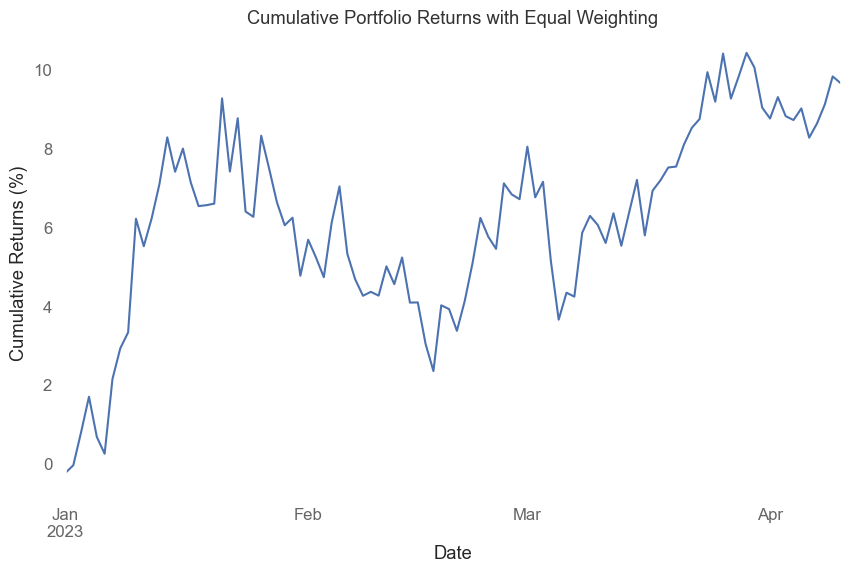

In [ ]:
import numpy as np
import pandas as pd

# Sample data: historical returns of three strategies (daily returns)
np.random.seed(42)  # For reproducibility
dates = pd.date_range(start='2023-01-01', periods=100, freq='D')
strategy_returns = pd.DataFrame(
    {
        "Strategy_A": np.random.normal(0.001, 0.01, 100),
        "Strategy_B": np.random.normal(0.0005, 0.015, 100),
        "Strategy_C": np.random.normal(0.0008, 0.02, 100),
    },
    index=dates,
)

# Equal weighting for all strategies
num_strategies = len(strategy_returns.columns)
equal_weights = np.array([1 / num_strategies] * num_strategies)

# Calculate portfolio returns with equal weighting
equal_returns = np.dot(equal_weights, strategy_returns.transpose())

# Convert the result to a Pandas Series for cumulative return calculation
portfolio_returns = pd.Series(equal_returns, index=dates)

# Calculate cumulative returns in percentage
cum_equal_weighted_returns = ((1 + portfolio_returns).cumprod() - 1) * 100

# Display results
print("Cumulative Returns (%):")
print(cum_equal_weighted_returns)

# Optionally, plot cumulative returns
import matplotlib.pyplot as plt

cum_equal_weighted_returns.plot(title="Cumulative Portfolio Returns with Equal Weighting", figsize=(10, 6))
plt.xlabel("Date")
plt.ylabel("Cumulative Returns (%)")
plt.grid()
plt.show()


In [ ]:
portfolio_returns

2023-01-01   -0.002269
2023-01-02    0.001941
2023-01-03    0.008432
2023-01-04    0.008857
2023-01-05   -0.010005
                ...   
2023-04-06   -0.006805
2023-04-07    0.003332
2023-04-08    0.004454
2023-04-09    0.006494
2023-04-10   -0.001533
Freq: D, Length: 100, dtype: float64

In [ ]:
strategy_returns.transpose()

,2023-01-01,2023-01-02,2023-01-03,2023-01-04,2023-01-05,2023-01-06,2023-01-07,2023-01-08,2023-01-09,2023-01-10,...,2023-04-01,2023-04-02,2023-04-03,2023-04-04,2023-04-05,2023-04-06,2023-04-07,2023-04-08,2023-04-09,2023-04-10
Strategy_A,0.005967,-0.000383,0.007477,0.016230,-0.001342,-0.001341,0.016792,0.008674,-0.003695,0.006426,...,0.001971,0.010686,-0.006021,-0.002277,-0.002921,-0.013635,0.003961,0.003611,0.001051,-0.001346
Strategy_B,-0.020731,-0.005810,-0.004641,-0.011534,-0.001919,0.006561,0.028793,0.003119,0.004363,-0.000617,...,-0.006198,0.013346,0.003711,-0.018186,0.003098,0.006280,-0.012758,0.002806,0.001373,-0.016645
Strategy_C,0.007956,0.012016,0.022461,0.021876,-0.026753,-0.017957,0.011101,0.011076,0.011101,0.077855,...,-0.003362,-0.009060,-0.010987,0.017792,0.007940,-0.013058,0.018792,0.006946,0.017057,0.013393


In [ ]:
equal_weights

array([0.33333333, 0.33333333, 0.33333333])

Best x: 1.9808225345208945
Best f(x): 2.999632224817798


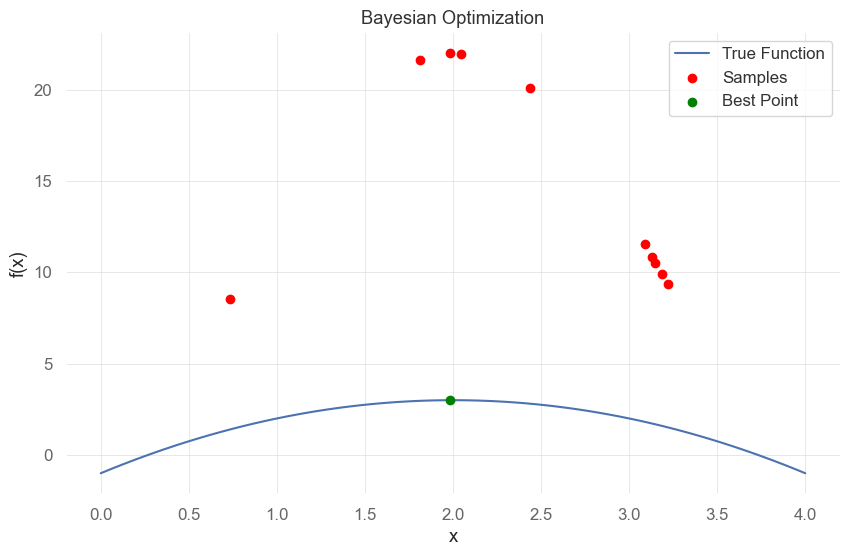

In [ ]:
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args

# Define the function to optimize
def f(x):
    return - (x - 2)**2 + 3

# Define the search space (x in [0, 4])
search_space = [Real(0.0, 4.0, name='x')]

# Wrap the function for skopt
@use_named_args(search_space)
def objective(x):
    return -f(x)  # Minimize the negative for maximization

"""
Without the above decorator, we would have to unpack the arguments manually:
from skopt.space import Real, Integer
from skopt import gp_minimize

search_space = [Real(0.0, 1.0, name='x'), Integer(1, 10, name='y')]

def objective(args):  # Takes a list of arguments
    x = args[0]       # Manually unpack the first element
    y = args[1]       # Manually unpack the second element
    return x**2 + y

result = gp_minimize(objective, search_space, n_calls=10)
print(result.x)
"""

# Perform Bayesian Optimization
result = gp_minimize(
    func=objective,          # Objective function
    dimensions=search_space, # Search space
    n_calls=10,              # Number of evaluations
    n_initial_points=2,      # Initial random evaluations
    random_state=42          # For reproducibility
)

# Results
print(f"Best x: {result.x[0]}")
print(f"Best f(x): {f(result.x[0])}")

# Plotting the optimization process (optional)
import matplotlib.pyplot as plt
import numpy as np

# Create points to visualize the function
x = np.linspace(0, 4, 100)
y = f(x)

# Plot the function
plt.plot(x, y, label="True Function")
plt.scatter(result.x_iters, [-f(xi) for xi in result.func_vals], color='red', label="Samples")
plt.scatter(result.x[0], f(result.x[0]), color='green', label="Best Point", zorder=5)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Bayesian Optimization")
plt.legend()
plt.show()
